<a href="https://colab.research.google.com/github/emcgeever-husky/Econ3916/blob/main/LAB%204/Descriptive%20Statistics%20%26%20Anomaly%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initializing

In [34]:
# libraries & housing data
from sklearn.datasets import fetch_california_housing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

In [35]:
# Take in Data
data = fetch_california_housing(as_frame=True)
df = data.frame

count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: MedHouseVal, dtype: float64


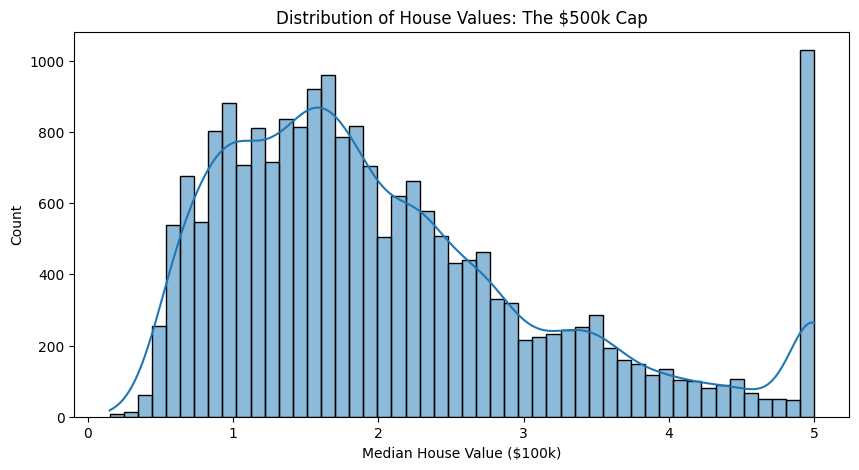

In [36]:
# Observing "Ceiling Effect"
print(df['MedHouseVal'].describe())

plt.figure(figsize=(10, 5))
sns.histplot(df['MedHouseVal'], bins=50, kde=True)
plt.title("Distribution of House Values: The $500k Cap")
plt.xlabel("Median House Value ($100k)")
plt.show()

## Breaking Down Outliers

In [37]:
def flag_outliers_iqr(df, column):
    # Calculate Quartiles
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define the "Tukey Fence"
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Return Boolean Mask
    return (df[column] < lower_bound) | (df[column] > upper_bound)

# Apply to Median Income
df['outlier_iqr'] = flag_outliers_iqr(df, 'MedInc')

print(f"Manual Outliers Detected: {df['outlier_iqr'].sum()}")
print("These are primarily the 'Wealthy' districts.")

Manual Outliers Detected: 681
These are primarily the 'Wealthy' districts.


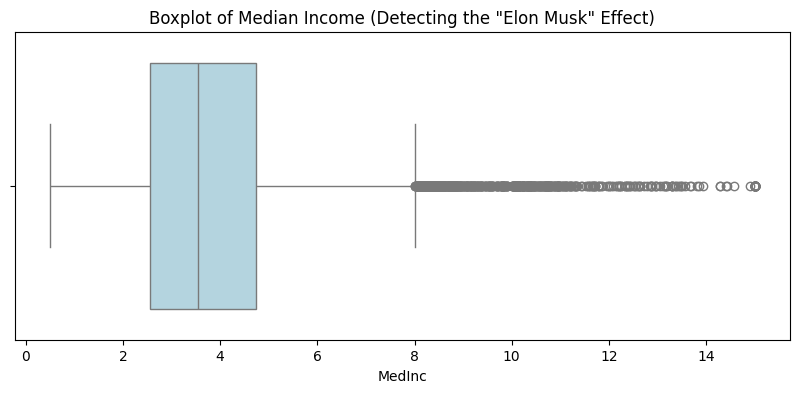

In [38]:
## Visualize outliers
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['MedInc'], color='lightblue')
plt.title('Boxplot of Median Income (Detecting the "Elon Musk" Effect)')
plt.show()

In [39]:
## Multivariate Anomolies via Isolation Forest
# contamination=0.05 -- estimates ~5% of the data is anomalous
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)

# variables to analyze (Income, House Age, Average Rooms)
variables = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population']

# Fit and Predict (-1 = Outlier, 1 = Normal)
preds = iso_forest.fit_predict(df[variables])

# Map to boolean (True if outlier)
df['outlier_iso'] = preds == -1

print(f"Algorithmic Outliers Detected: {df['outlier_iso'].sum()}")

Algorithmic Outliers Detected: 1032


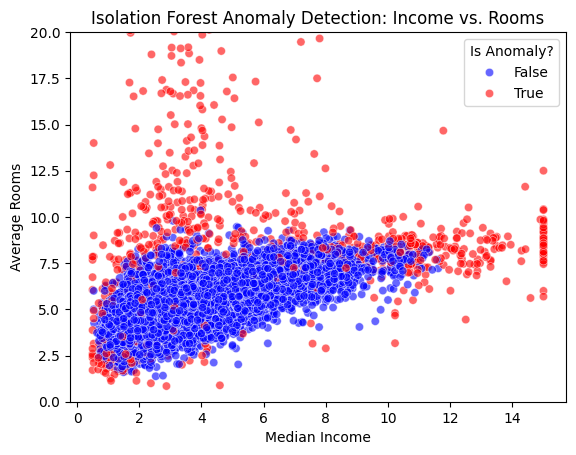

In [40]:
# Visualize
# Plot points flagged by Isolation Forest
sns.scatterplot(
    data=df,
    x='MedInc',
    y='AveRooms',
    hue='outlier_iso',
    palette={True: 'red', False: 'blue'},
    alpha=0.6
)

plt.title("Isolation Forest Anomaly Detection: Income vs. Rooms")
plt.xlabel("Median Income")
plt.ylabel("Average Rooms")
plt.ylim(0, 20) # Zoom in to ignore extreme errors
plt.legend(title='Is Anomaly?')
plt.show()

## Understanding the Difference between Normal and Anomolous Data


In [41]:
## Isolating Anolomies and Analysizing difference
df_normal = df[df['outlier_iso'] == False]
df_outlier = df[df['outlier_iso'] == True]

In [42]:
# Mean & Median
summary_stats = pd.DataFrame({
    'Group': ['Normal', 'Outlier'],
    'MedInc_Mean': [
        df_normal['MedInc'].mean(),
        df_outlier['MedInc'].mean()
    ],
    'MedInc_Median': [
        df_normal['MedInc'].median(),
        df_outlier['MedInc'].median()
    ],
    'MedHouseVal_Mean': [
        df_normal['MedHouseVal'].mean(),
        df_outlier['MedHouseVal'].mean()
    ],
    'MedHouseVal_Median': [
        df_normal['MedHouseVal'].median(),
        df_outlier['MedHouseVal'].median()
    ]
})

In [43]:
# Standard Deviations & Median Absolute Volatility (MAD)
def mad(series):
    return np.median(np.abs(series - np.median(series)))

volatility = pd.DataFrame({
    'Group': ['Normal', 'Outlier'],
    'MedInc_STD': [
        df_normal['MedInc'].std(),
        df_outlier['MedInc'].std()
    ],
    'MedInc_MAD': [
        mad(df_normal['MedInc']),
        mad(df_outlier['MedInc'])
    ],
    'MedHouseVal_STD': [
        df_normal['MedHouseVal'].std(),
        df_outlier['MedHouseVal'].std()
    ],
    'MedHouseVal_MAD': [
        mad(df_outlier['MedHouseVal']),
        mad(df_outlier['MedHouseVal'])
    ]
})

In [44]:
# 'Inequality Wedge' -- Summary Stats
inequality_wedge = pd.DataFrame({
    'Metric': ['MedInc', 'MedHouseVal'],
    'Mean': [
        df_outlier['MedInc'].mean(),
        df_outlier['MedHouseVal'].mean()
    ],
    'Median': [
        df_outlier['MedInc'].median(),
        df_outlier['MedHouseVal'].median()
    ]
})

inequality_wedge['Inequality_Wedge'] = (
    inequality_wedge['Mean'] - inequality_wedge['Median']
)

print("=== Inequality Wedge (Outliers Only) ===")
print(inequality_wedge)



=== Inequality Wedge (Outliers Only) ===
        Metric      Mean   Median  Inequality_Wedge
0       MedInc  5.790782  4.25695          1.533832
1  MedHouseVal  2.668172  2.05700          0.611172


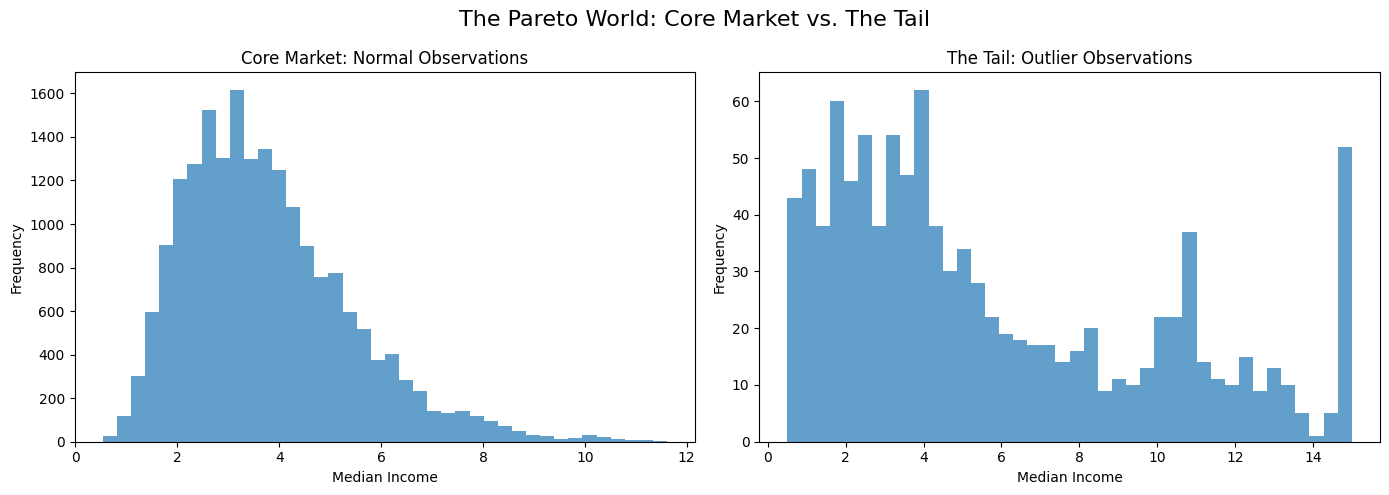

In [45]:
## Visualizing the difference
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(df_normal['MedInc'], bins=40, alpha=0.7)
plt.title('Core Market: Normal Observations')
plt.xlabel('Median Income')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df_outlier['MedInc'], bins=40, alpha=0.7)
plt.title('The Tail: Outlier Observations')
plt.xlabel('Median Income')
plt.ylabel('Frequency')

plt.suptitle('The Pareto World: Core Market vs. The Tail', fontsize=16)
plt.tight_layout()
plt.show()